In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def transform1(series):
    return series
def transform2(series):
    a = series.diff().fillna(0)
    return a
def transform3(series):
    a = 2* series.diff().diff().fillna(0)
    return a
def transform4(series):
    return pd.Series(np.log(series)).fillna(0)
def transform5(series):
    a = pd.Series(np.log(series)).diff().fillna(0)
    return a
def transform6(series):
    a = pd.Series(np.log(series)).diff().diff().fillna(0)
    return a
def transform7(series):
    a = series.div(series.shift(-1)).fillna(0)
    return a

functions = [transform1, transform2, transform3, transform4, transform5, transform6, transform7]

def get_transformed_data(path, transform = True, lag = 6):
    df = pd.read_csv(path)
    df2  = {}
    for name in df.columns:
        if(df[name].isna().sum() > 0 or name == 'sasdate'):
            continue
        df2[name] = functions[int(df[name][0])-1](df[name][1:]) if transform else functions[1](df[name][1:])
        for i in range(1,lag):
            df2[name+"_sb"+str(i)] = df2[name].shift(i).fillna(0)

    df2 = pd.DataFrame(data=df2)
    return df2

In [36]:
df = get_transformed_data('FedData/2014-12.csv', transform=False)
df

,RPI,RPI_sb1,RPI_sb2,RPI_sb3,RPI_sb4,RPI_sb5,W875RX1,W875RX1_sb1,W875RX1_sb2,W875RX1_sb3,...,MZMSL_sb2,MZMSL_sb3,MZMSL_sb4,MZMSL_sb5,INVEST,INVEST_sb1,INVEST_sb2,INVEST_sb3,INVEST_sb4,INVEST_sb5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.8,0.0,0.0,0.0,0.0,0.0,8.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.7,0.0,0.0,0.0,0.0,0.0
3,14.8,9.8,0.0,0.0,0.0,0.0,15.9,8.3,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.9,-0.7,0.0,0.0,0.0,0.0
4,14.1,14.8,9.8,0.0,0.0,0.0,14.2,15.9,8.3,0.0,...,1.1,0.0,0.0,0.0,0.2,-1.9,-0.7,0.0,0.0,0.0
5,14.0,14.1,14.8,9.8,0.0,0.0,15.3,14.2,15.9,8.3,...,1.4,1.1,0.0,0.0,-1.1,0.2,-1.9,-0.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,19.8,24.7,12.3,3.6,62.7,67.6,14.2,19.3,0.4,0.3,...,77.1,29.1,39.3,103.1,24.5,17.8,23.2,10.3,19.1,16.4
668,51.7,19.8,24.7,12.3,3.6,62.7,36.8,14.2,19.3,0.4,...,42.1,77.1,29.1,39.3,1.0,24.5,17.8,23.2,10.3,19.1
669,14.1,51.7,19.8,24.7,12.3,3.6,12.1,36.8,14.2,19.3,...,80.3,42.1,77.1,29.1,18.3,1.0,24.5,17.8,23.2,10.3
670,39.0,14.1,51.7,19.8,24.7,12.3,40.6,12.1,36.8,14.2,...,20.6,80.3,42.1,77.1,6.7,18.3,1.0,24.5,17.8,23.2


In [37]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

df = get_transformed_data('FedData/2014-12.csv', transform=False, lag=4)
x_train, x_test, y_train, y_test = train_test_split(df, df['CPIULFSL'].shift(-1).fillna(0), shuffle=False)

l = Lasso(alpha=0.9)
l.fit(x_train, y_train)
print(l.score(x_test, y_test))
print(np.sum(np.sqrt((l.predict(x_test)-y_test)**2))*(1/len(y_test)))

importance = np.abs(l.coef_)
np.array(df.columns)[importance > 2*importance.std() + importance.mean()]

-0.4729894194089481
0.6675818793958292


array(['UEMP15OV_sb3', 'PAYEMS', 'USGOOD_sb2', 'USGOOD_sb3', 'MANEMP_sb1',
       'MANEMP_sb2', 'USGOVT_sb2', 'HOUST', 'HOUST_sb1', 'HOUST_sb2',
       'HOUST_sb3'], dtype=object)

0.2346158963371866
0.5131255673169801


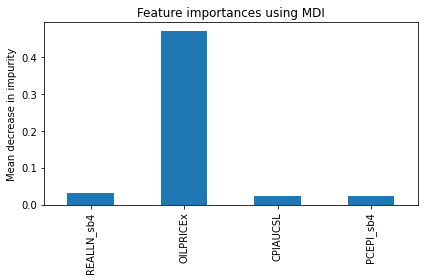

In [38]:
df = get_transformed_data('current.csv', transform=False)
l = RandomForestRegressor(max_depth=3, n_estimators=500)
x_train, x_test, y_train, y_test = train_test_split(df, df['CPIULFSL'].shift(-1).fillna(0), shuffle=False)
l.fit(x_train, y_train)
print(l.score(x_test, y_test))
print(np.sum(np.sqrt((l.predict(x_test)-y_test)**2))*(1/len(y_test)))

result = permutation_importance(
    l, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=df.columns)
top_importance = forest_importances[forest_importances > np.std(forest_importances)+np.mean(forest_importances)]
fig, ax = plt.subplots()
top_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

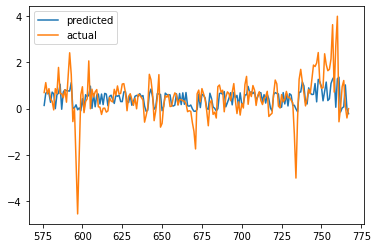

In [45]:
x = l.predict(df)
start = int(0.75*len(x))
plt.plot(range(start, len(x)), x[start:], label= 'predicted')
plt.plot(range(start, len(x)), df['CPIULFSL'].shift(-1).fillna(0)[start:], label='actual')
plt.legend()
plt.show()

In [46]:
pd.DataFrame(x).to_csv("predicted_cpi_delta.csv")